In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score,confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
   

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
# calculate class weights based on the training data

OSError: dlopen(/Users/natalie/anaconda3/lib/python3.8/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <C3EB28DD-60B6-3334-AFA2-72BBBF9DBAEF> /Users/natalie/anaconda3/lib/python3.8/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [4]:
import pandas as pd
import lightgbm as lgb

print(pd.__version__)
print(lgb.__version__)

OSError: dlopen(/Users/natalie/anaconda3/lib/python3.8/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <C3EB28DD-60B6-3334-AFA2-72BBBF9DBAEF> /Users/natalie/anaconda3/lib/python3.8/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [2]:
test = pd.read_parquet('/Users/natalie/Desktop/DS Thesis/Code/data/test.parquet')
train = pd.read_parquet('/Users/natalie/Desktop/DS Thesis/Code/data/train.parquet')

In [3]:
TARGET ='churn_user'
CATEGORICAL_FEATURES  = ['os_name', 'age_group','gender', 'country', 'region', 'province_type',
                         'province']
DATETIME_FEATURES  = ['first_date', 'lastest_active_day']
SEARCH_CC_FEATURES = [ 'clicks', 'search_volume', 'dating_search', 'videoclip_search', 'technical_search', 'housekeeping_family_search', 'marketing_search', 'other_search']
SEARCH_GG_FEATURES = [ 'serp_click', 'search_volume_gg', 'search_clicks_gg', 'other_search_gg','housekeeping_family_search_gg','videoclip_search_gg', 'dating_search_gg', 'marketing_search_gg', 'technical_search_gg']
ACTIVE_FEATURES = ['active_day', 'life_time',  'not_active_day', 'total_active_time']
ADS_FEATURES =  ['ads_impression', 'ads_click', 'ads_revenue']
OTHERS_FEATURES =[ 'newtab_count', 'download_count', 'pip_count', 'sidebar_count', 'incognito_count', 'signin_count', 'youtube_count',
                    'work_count', 'social_count', 'news_count', 'entertainment_count', 'ecommerce_count']
NUMERICAL_FEATURES = SEARCH_CC_FEATURES + SEARCH_GG_FEATURES + ACTIVE_FEATURES + ADS_FEATURES + OTHERS_FEATURES
MODEL_NAMES = ['log_reg', 'randomforest','lightgbm', 'xgboost', 'mlp']


In [4]:
def find_best_threshold_f1_score(train_labels, oofs, average='macro'):
    scores = []
    thresholds = []
    best_score = 0
    best_threshold = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        print(f'{threshold:.02f}, ', end='')
        preds = (oofs > threshold).astype('int')
        m = f1_score(train_labels, preds, average=average)
        scores.append(m)
        thresholds.append(threshold)
        if m > best_score:
            best_score = m
            best_threshold = threshold
    return best_threshold, best_score


In [5]:
def flat_feature_engineer(df):
    temp = pd.DataFrame()
    temp['OTHERS_FEATURES_SUM'] = df[OTHERS_FEATURES].sum(axis=1)
    temp['OTHERS_FEATURES_MIN'] = df[OTHERS_FEATURES].min(axis=1)
    temp['OTHERS_FEATURES_MAX'] = df[OTHERS_FEATURES].max(axis=1)
    temp['OTHERS_FEATURES_MEAN'] = df[OTHERS_FEATURES].mean(axis=1)
    temp['ADS_CTR'] = df['ads_click'] / df['ads_impression']
    temp['SEARCH_CC_FEATURES_SUM'] = df[SEARCH_CC_FEATURES[1:]].sum(axis=1)
    temp['SEARCH_CC_FEATURES_MIN'] = df[SEARCH_CC_FEATURES[1:]].min(axis=1)
    temp['SEARCH_CC_FEATURES_MAX'] = df[SEARCH_CC_FEATURES[1:]].max(axis=1)
    temp['SEARCH_CC_FEATURES_MEAN'] = df[SEARCH_CC_FEATURES[1:]].mean(axis=1)
    temp['SEARCH_GG_FEATURES_SUM'] = df[SEARCH_GG_FEATURES[1:]].sum(axis=1)
    temp['SEARCH_GG_FEATURES_MIN'] = df[SEARCH_GG_FEATURES[1:]].min(axis=1)
    temp['SEARCH_GG_FEATURES_MAX'] = df[SEARCH_GG_FEATURES[1:]].max(axis=1)
    temp['SEARCH_GG_FEATURES_MEAN'] = df[SEARCH_GG_FEATURES[1:]].mean(axis=1)
    temp['not_active_day_per_active_day'] = df['not_active_day'] / df['active_day']
    temp['life_time_per_active_day'] = df['life_time'] / df['active_day']
    return temp, list(temp.columns)

def fillna(df):
    df['total_active_time'] = df['total_active_time'].fillna(0)
    df['ads_impression'] = df['ads_impression'].fillna(0)
    df['ads_click'] = df['ads_click'].fillna(0)
    df['ads_revenue'] = df['ads_revenue'].fillna(0)
    df['clicks'] = df['clicks'].fillna(0)
    for c in OTHERS_FEATURES:
        df[c] = df[c].fillna(0)
    return df

def process_data(df,oh_encoder=None, robust_scaler=None,agg_features=None):
    if not oh_encoder:
        print("fit train OneHotEncoder")
        oh_encoder = OneHotEncoder()
        oh_encoder.fit(df[CATEGORICAL_FEATURES])
    else:
        print("loadd onehot encoder")
    if not robust_scaler:
        print("fit train RobustScaler")
        robust_scaler = RobustScaler()
        robust_scaler.fit(df[NUMERICAL_FEATURES])
    else:
        print("loadd robust scaler")
    df_cat = pd.DataFrame(oh_encoder.transform(df[CATEGORICAL_FEATURES]).toarray())
    new_cat_cols = oh_encoder.get_feature_names_out(CATEGORICAL_FEATURES)
    df_cat.columns = new_cat_cols
    df_num = pd.DataFrame(robust_scaler.transform(df[NUMERICAL_FEATURES]))
    df_num.columns = NUMERICAL_FEATURES
    new_df = pd.concat([df_cat.reset_index(drop=True), df_num.reset_index(drop=True)], axis=1)
    new_df = fillna(new_df)
    return new_df, oh_encoder, robust_scaler

In [58]:
N_ESTIMATORS = 200
SEED=42
LGBM_Hyperparameters =  {
    "n_estimators": N_ESTIMATORS,
    'learning_rate':0.03,
     'max_depth':8,
     'colsample_bytree':0.8,
     'subsample':0.8,
     # 'reg_alpha':8,
     # 'reg_lambda':32,

    "random_state":SEED,
    'device':'gpu',
#     "class_weight": "balanced"
}

XGBoost_Hyperparameters = {
    'objective' : 'binary:logistic',
     'eval_metric':['logloss', 'auc'],
     'n_estimators':N_ESTIMATORS,
     'learning_rate':0.03,
     'max_depth':8,
     'colsample_bytree':0.5,
     'subsample':0.8,
     'reg_alpha':8,
     'reg_lambda':32,
     'seed':SEED,
     # 'scale_pos_weight':3,
     'enable_categorical':True,
     'early_stopping_rounds': 50,
     'tree_method':'gpu_hist'}
RF_Hyperparameters = {
    'n_estimators': N_ESTIMATORS,
    'max_depth':8,
    'random_state':SEED,
    'max_features': 'sqrt', 
    'n_jobs': -1
}
Logreg_Hyperparameters = {'max_iter':N_ESTIMATORS,'random_state':SEED} 
MLP_Hyperparametesr = {'hidden_layer_sizes':(3,125), 'random_state':SEED, 'max_iter':min(N_ESTIMATORS,100)}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

def cross_validate(train, USE_SMOTE=False, USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    oofs = np.zeros((train.shape[0], len(MODEL_NAMES)))
    for i, (train_index, valid_index) in enumerate(kfold.split(train, train[TARGET])):
        print(f"===========fold {i}================")
        X_train, oh_encoder, robust_scaler = process_data(train.iloc[train_index])
        X_valid, _, _  = process_data(train.iloc[valid_index], oh_encoder,robust_scaler)
        print(X_train.isnull().sum())
        y_train = train.iloc[train_index][TARGET].values
        y_valid = train.iloc[valid_index][TARGET].values
        logreg_hyperparameters = Logreg_Hyperparameters.copy()
        lgb_hyperparameters = LGBM_Hyperparameters.copy()
        xgboost_hyperparameters = XGBoost_Hyperparameters.copy()
        rf_hyperparameters = RF_Hyperparameters.copy()
        mlp_hyperparameters = MLP_Hyperparametesr.copy()
        if USE_SMOTE:
            print("SMOTEEEE")
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
        elif USE_CLASS_WEIGHT:
            print("CLASS_WEIGHTTTT")
           
            class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
            class_weights =  {0: class_weights[0], 1: class_weights[1]}
            lgb_hyperparameters['class_weight'] = class_weights
            logreg_hyperparameters['class_weight'] = class_weights
            xgboost_hyperparameters['scale_pos_weight'] = class_weights[1] /  class_weights[0]
            rf_hyperparameters['class_weight'] = class_weights
        elif USE_UNDER_SAMPLING:
            print("UNDER SAMPLING")
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
        print("LOGREG--------------")
        logreg_model = LogisticRegression(**logreg_hyperparameters)
        logreg_model.fit(X_train, y_train)
        logreg_y_pred_proba = logreg_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, logreg_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in logreg_y_pred_proba]

        print(roc_auc_score(y_valid, logreg_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,0] = logreg_y_pred_proba

        print("Random Forest--------------")
        rf_model = RandomForestClassifier(**rf_hyperparameters)
        rf_model.fit(X_train, y_train)
        rf_y_pred_proba = rf_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, rf_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in rf_y_pred_proba]

        print(roc_auc_score(y_valid, rf_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,1] = rf_y_pred_proba
    #     models.append(model)
        print("LGBModel--------------")
        lgb_model = LGBMClassifier(**lgb_hyperparameters)
        callbacks = [lgb.early_stopping(200, verbose=50), lgb.log_evaluation(period=50)]
        lgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric=["logloss", "auc"],
                  callbacks=callbacks)

        lgb_y_pred_proba = lgb_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, lgb_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in lgb_y_pred_proba]
        print(roc_auc_score(y_valid, lgb_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,2] = lgb_y_pred_proba
    #     models.append(model)
        # display(pd.DataFrame({'score': lgb_model.feature_importances_, 'feature': lgb_model.feature_name_}).sort_values('score',ascending=False))

        print("XGBoost--------------")
        xgb_model = XGBClassifier(**xgboost_hyperparameters)
        xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=50)
        xgb_y_pred_proba = xgb_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, xgb_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in xgb_y_pred_proba]
        print(roc_auc_score(y_valid, xgb_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index, 3] = xgb_y_pred_proba
        
        print("MLP------------------")
        mlp_model = MLPClassifier(**mlp_hyperparameters)
        mlp_model.fit(X_train, y_train)
        mlp_y_pred_proba = mlp_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, mlp_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in mlp_y_pred_proba]
        print(roc_auc_score(y_valid, mlp_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index, 4] = mlp_y_pred_proba
    return oofs

In [59]:
accuracy_scores = []
f1_scores = []
auc_scores = []
specificity_scores = []
sensitivity_scores = []
def scoring(y_test,y_pred_proba, best_threshold):
    y_pred = [1 if y_hat >= best_threshold else 0 for y_hat in y_pred_proba]
    acc = accuracy_score(y_test, y_pred)
    _f1_score = f1_score(y_test, y_pred, average='macro')
    auc_score = roc_auc_score(y_test, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    print("accuracy", acc)
    print("f1_score", _f1_score)
    print("auc", auc_score)
    print("sensitivity", sensitivity, "specificity", specificity)
    print(classification_report(y_test, y_pred, digits=4))
    return acc, _f1_score, auc_score, specificity, sensitivity

In [87]:
def train_model(oofs,X_train, y_train, X_test, y_test, USE_SMOTE=False,USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    models = []
    predictions = []
    accuracy_scores = []
    f1_scores = []
    auc_scores = []
    specificity_scores = []
    sensitivity_scores = []
    best_thresholds = []
    for i in range(len(MODEL_NAMES)):
        best_threshold, best_score = find_best_threshold_f1_score(train[TARGET].values, oofs[:,i])
        best_thresholds.append(best_threshold)
        print('\n',best_threshold, best_score)
    logreg_hyperparameters = Logreg_Hyperparameters.copy()
    lgb_hyperparameters = LGBM_Hyperparameters.copy()
    xgboost_hyperparameters = XGBoost_Hyperparameters.copy()
    del xgboost_hyperparameters['early_stopping_rounds']
    rf_hyperparameters = RF_Hyperparameters.copy()
    mlp_hyperparameters = MLP_Hyperparametesr.copy()
    if USE_SMOTE:
        print("SMOTEEEE")
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    elif USE_CLASS_WEIGHT:
        print("CLASS_WEIGHTTTT")
        class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        class_weights =  {0: class_weights[0], 1: class_weights[1]}
        lgb_hyperparameters['class_weight'] = class_weights
        logreg_hyperparameters['class_weight'] = class_weights
        xgboost_hyperparameters['scale_pos_weight'] = class_weights[1]/ class_weights[0]
        rf_hyperparameters['class_weight'] = class_weights
    elif USE_UNDER_SAMPLING:
        print("UNDER SAMPLING")
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)

    print("LOGREG--------------")
    logreg_model = LogisticRegression(**logreg_hyperparameters)
    logreg_model.fit(X_train, y_train)
    logreg_y_pred_proba = logreg_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,logreg_y_pred_proba,best_thresholds[0])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(logreg_y_pred_proba)
    models.append(logreg_model)

    print("Random Forest--------------")
    rf_model = RandomForestClassifier(**rf_hyperparameters)
    rf_model.fit(X_train, y_train)
    rf_y_pred_proba = rf_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,rf_y_pred_proba,best_thresholds[1])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(rf_y_pred_proba)
    models.append(rf_model)

    print("LGBModel--------------")
    lgb_model = LGBMClassifier(**lgb_hyperparameters)
    lgb_model.fit(X_train, y_train)
    lgb_y_pred_proba = lgb_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,lgb_y_pred_proba,best_thresholds[2])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(lgb_y_pred_proba)
    models.append(lgb_model)

    print("XGBoost--------------")
    print(xgboost_hyperparameters)
    xgb_model = XGBClassifier(**xgboost_hyperparameters)
    xgb_model.fit(X_train, y_train)
    xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,xgb_y_pred_proba,best_thresholds[3])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(xgb_y_pred_proba)
    models.append(xgb_model)
    
    print("MLP--------------")
    mlp_model = MLPClassifier(**mlp_hyperparameters)
    mlp_model.fit(X_train, y_train)
    mlp_y_pred_proba = mlp_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,mlp_y_pred_proba,best_thresholds[4])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(mlp_y_pred_proba)
    models.append(mlp_model)

    print(MODEL_NAMES)
    print(accuracy_scores)
    print(f1_scores)
    print(auc_scores)
    print(specificity_scores)
    print(sensitivity_scores)
    score_df = pd.DataFrame({'model_name': MODEL_NAMES,
                         'accuracy_score':accuracy_scores, 
                         'f1_score': f1_scores, 
                         'auc_score': auc_scores, 
                         'specificity_score': specificity_scores, 
                         'sensitivity_score': sensitivity_scores})
    return score_df,models, predictions

In [88]:
X_train,oh_encoder,robust_scaler = process_data(train)
X_test, _,_ = process_data(test,oh_encoder,robust_scaler)
y_train = train[TARGET].values
y_test = test[TARGET].values

fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler


In [89]:
# print("Not handle Balanced")
# nothing_oofs = cross_validate(train)
# nothing_score_df, nothing_models, nothing_predictions = train_model(nothing_oofs,X_train, y_train, X_test, y_test)

# print("Use SMOTE")
# smote_oofs = cross_validate(train, USE_SMOTE=True)
# smote_score_df, smote_models, smote_predictions = train_model(smote_oofs,X_train, y_train, X_test, y_test, USE_SMOTE=True)

print("Use Class weight")
# class_weight_oofs = cross_validate(train, USE_CLASS_WEIGHT=True)
class_weight_score_df, class_weight_models, class_weight_predictions = train_model(class_weight_oofs,X_train, y_train, X_test, y_test, USE_CLASS_WEIGHT=True)

# print("Use Under sampling")
# under_sampling_oofs = cross_validate(train, USE_UNDER_SAMPLING=True)
# under_sampling_score_df, under_sampling_models, under_sampling_predictions = train_model(under_sampling_oofs,X_train, y_train, X_test, y_test, USE_UNDER_SAMPLING=True)

Use Class weight
0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
 0.6899999999999997 0.7681388619721978
0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0

In [90]:
import pickle

In [91]:
# with open(f"../checkpoints/nothing_model_{N_ESTIMATORS}_estimators.pkl", "wb") as f:
#     pickle.dump({
#         "score_df": nothing_score_df,
#         "oofs": nothing_oofs,
#         "models": nothing_models,
#         "model_names": MODEL_NAMES,
#         "predictions":nothing_predictions},f,protocol=pickle.HIGHEST_PROTOCOL)
    
# with open(f"../checkpoints/smote_model_{N_ESTIMATORS}_estimators.pkl", "wb") as f:
#     pickle.dump({
#             "score_df":smote_score_df,
#             "oofs": smote_oofs,
#             "models": smote_models,
#             "model_names": MODEL_NAMES,
#             "predictions":smote_predictions},f,protocol=pickle.HIGHEST_PROTOCOL)    

with open(f"../checkpoints/class_weight_model_{N_ESTIMATORS}_estimators.pkl", "wb") as f:
    pickle.dump({
            "score_df":class_weight_score_df,
            "oofs": class_weight_oofs,
            "models": class_weight_models,
            "model_names": MODEL_NAMES,
            "predictions":class_weight_predictions},f,protocol=pickle.HIGHEST_PROTOCOL)
    
# with open(f"../checkpoints/under_sampling_model_{N_ESTIMATORS}_estimators.pkl", "wb") as f:
#     pickle.dump({
#             "score_df":under_sampling_score_df,
#             "oofs": under_sampling_oofs,
#             "models": under_sampling_models,
#             "model_names": MODEL_NAMES,
#             "predictions":under_sampling_predictions},f,protocol=pickle.HIGHEST_PROTOCOL)



<Axes: >

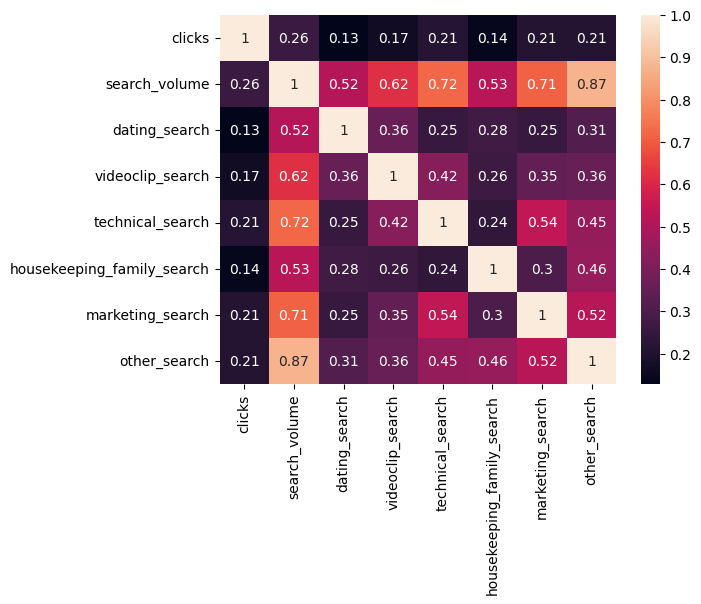

In [51]:
sns.heatmap(train[SEARCH_CC_FEATURES].corr(),annot=True)

<Axes: >

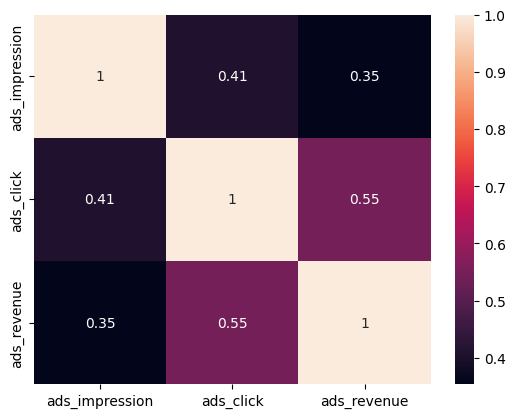

In [52]:
sns.heatmap(train[ADS_FEATURES].corr(),annot=True)

In [47]:
corr_df =train[NUMERICAL_FEATURES].corr()
for col in NUMERICAL_FEATURES:
    display(corr_df[col].sort_values(ascending=False).head())

clicks               1.000000
total_active_time    0.437201
newtab_count         0.358348
ads_impression       0.330719
search_volume        0.262912
Name: clicks, dtype: float64

search_volume       1.000000
serp_click          0.911046
other_search        0.873868
technical_search    0.722837
marketing_search    0.713562
Name: search_volume, dtype: float64

dating_search       1.000000
serp_click          0.523105
search_volume       0.519251
videoclip_search    0.360385
other_search        0.311863
Name: dating_search, dtype: float64

videoclip_search    1.000000
search_volume       0.620036
serp_click          0.592490
technical_search    0.422911
newtab_count        0.405729
Name: videoclip_search, dtype: float64

technical_search    1.000000
search_volume       0.722837
serp_click          0.672005
marketing_search    0.540135
newtab_count        0.517872
Name: technical_search, dtype: float64

housekeeping_family_search    1.000000
search_volume                 0.526120
serp_click                    0.460967
other_search                  0.455391
ads_impression                0.348435
Name: housekeeping_family_search, dtype: float64

marketing_search    1.000000
search_volume       0.713562
serp_click          0.649157
technical_search    0.540135
other_search        0.522123
Name: marketing_search, dtype: float64

other_search        1.000000
search_volume       0.873868
serp_click          0.766952
newtab_count        0.526768
marketing_search    0.522123
Name: other_search, dtype: float64

serp_click          1.000000
search_volume       0.911046
other_search        0.766952
technical_search    0.672005
marketing_search    0.649157
Name: serp_click, dtype: float64

search_volume_gg                 1.000000
other_search_gg                  0.934680
housekeeping_family_search_gg    0.822599
search_clicks_gg                 0.752413
marketing_search_gg              0.703819
Name: search_volume_gg, dtype: float64

search_clicks_gg       1.000000
search_volume_gg       0.752413
other_search_gg        0.628690
technical_search_gg    0.626359
marketing_search_gg    0.603459
Name: search_clicks_gg, dtype: float64

other_search_gg                  1.000000
search_volume_gg                 0.934680
housekeeping_family_search_gg    0.849527
marketing_search_gg              0.642609
search_clicks_gg                 0.628690
Name: other_search_gg, dtype: float64

housekeeping_family_search_gg    1.000000
other_search_gg                  0.849527
search_volume_gg                 0.822599
search_clicks_gg                 0.549767
marketing_search_gg              0.545881
Name: housekeeping_family_search_gg, dtype: float64

videoclip_search_gg    1.000000
search_volume_gg       0.541017
dating_search_gg       0.434835
search_clicks_gg       0.382859
other_search_gg        0.352149
Name: videoclip_search_gg, dtype: float64

dating_search_gg       1.000000
search_volume_gg       0.483564
search_clicks_gg       0.441680
videoclip_search_gg    0.434835
marketing_search_gg    0.348865
Name: dating_search_gg, dtype: float64

marketing_search_gg              1.000000
search_volume_gg                 0.703819
other_search_gg                  0.642609
search_clicks_gg                 0.603459
housekeeping_family_search_gg    0.545881
Name: marketing_search_gg, dtype: float64

technical_search_gg    1.000000
search_clicks_gg       0.626359
search_volume_gg       0.586425
total_active_time      0.391341
marketing_search_gg    0.381083
Name: technical_search_gg, dtype: float64

active_day           1.000000
newtab_count         0.568413
ads_impression       0.563756
total_active_time    0.543566
signin_count         0.514902
Name: active_day, dtype: float64

life_time            1.000000
active_day           0.080573
signin_count         0.035755
total_active_time    0.027701
ads_impression       0.024184
Name: life_time, dtype: float64

not_active_day     1.000000
work_count        -0.014963
ecommerce_count   -0.019995
pip_count         -0.020098
news_count        -0.020161
Name: not_active_day, dtype: float64

total_active_time    1.000000
newtab_count         0.752773
ads_impression       0.717674
active_day           0.543566
search_volume_gg     0.526069
Name: total_active_time, dtype: float64

ads_impression       1.000000
newtab_count         0.938730
total_active_time    0.717674
search_volume        0.570123
active_day           0.563756
Name: ads_impression, dtype: float64

ads_click         1.000000
ads_revenue       0.546912
serp_click        0.409749
ads_impression    0.408833
search_volume     0.407061
Name: ads_click, dtype: float64

ads_revenue         1.000000
ads_click           0.546912
newtab_count        0.370912
technical_search    0.369694
search_volume       0.365030
Name: ads_revenue, dtype: float64

newtab_count         1.000000
ads_impression       0.938730
total_active_time    0.752773
search_volume        0.633969
serp_click           0.580594
Name: newtab_count, dtype: float64

download_count         1.000000
entertainment_count    0.056957
total_active_time      0.051283
dating_search_gg       0.046126
newtab_count           0.042146
Name: download_count, dtype: float64

pip_count              1.000000
technical_search_gg    0.082169
total_active_time      0.078816
search_clicks_gg       0.075452
youtube_count          0.067212
Name: pip_count, dtype: float64

sidebar_count        1.000000
total_active_time    0.208790
newtab_count         0.184506
search_volume        0.178699
serp_click           0.166404
Name: sidebar_count, dtype: float64

incognito_count     1.000000
search_volume       0.172900
dating_search       0.171167
serp_click          0.152006
videoclip_search    0.151261
Name: incognito_count, dtype: float64

signin_count     1.000000
active_day       0.514902
newtab_count     0.374588
search_volume    0.347462
serp_click       0.342604
Name: signin_count, dtype: float64

youtube_count          1.000000
videoclip_search_gg    0.305240
total_active_time      0.280782
search_volume_gg       0.274240
newtab_count           0.247305
Name: youtube_count, dtype: float64

work_count           1.000000
clicks               0.158759
total_active_time    0.116354
newtab_count         0.085939
ads_impression       0.080023
Name: work_count, dtype: float64

social_count         1.000000
total_active_time    0.302012
newtab_count         0.276206
ads_impression       0.242121
clicks               0.214268
Name: social_count, dtype: float64

news_count                    1.000000
ads_impression                0.103600
total_active_time             0.082720
housekeeping_family_search    0.070800
ads_click                     0.062247
Name: news_count, dtype: float64

entertainment_count    1.000000
total_active_time      0.144907
newtab_count           0.129417
dating_search          0.125535
serp_click             0.113520
Name: entertainment_count, dtype: float64

ecommerce_count                  1.000000
other_search_gg                  0.573945
housekeeping_family_search_gg    0.520513
search_volume_gg                 0.468170
total_active_time                0.274080
Name: ecommerce_count, dtype: float64

In [ ]:
X_train[trtra]